In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping
import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
!pip install lime
import lime
from lime import lime_tabular
import random
from numpy.random import seed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
#setting random seed for NN
import tensorflow
tensorflow.random.set_seed(42)

In [44]:
#Dataset load
ds_train = pd.read_csv("/clear_dataset.zip" , compression="zip")

In [11]:
ds_train.head()

,passenger_count,trip_duration,month_pickup,dow_pickup,hour_pickup,BoroCode,BoroName,dist_km,average_speed
0,1,455,3,0,17,1,Manhattan,1.498521,11.856428
1,1,663,6,6,0,1,Manhattan,1.805507,9.803659
2,1,2124,1,1,11,1,Manhattan,6.385098,10.822201
3,1,429,4,2,19,1,Manhattan,1.485498,12.465721
4,1,435,3,5,13,1,Manhattan,1.188588,9.836594


### Feature selection


Removal average speed since it is calculated based on the predicted variable

In [45]:
ds_train.drop(['average_speed', "BoroName"], axis=1, inplace=True)

### Y and X variables


In [46]:
#predict variable split
y_values = ds_train["trip_duration"]
x_values = ds_train.drop(["trip_duration"],axis=1)

## Pt.0 Random forest model as benchmark

In [ ]:
#split in train e validation set
train_X, val_X, train_y, val_y = train_test_split(x_values, y_values, test_size = 0.25, random_state = 12)

random_grid = {'max_depth': [3, 5, 10]}
random_forest = RandomForestRegressor()
random_forest_grid = RandomizedSearchCV(estimator = random_forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

random_forest_grid.fit(train_X, train_y)

predicted_trip_duration = random_forest_grid.predict(val_X)
MSLE = 	mean_squared_log_error(val_y , predicted_trip_duration)
print('Random forest validation MSLE = ', MSLE)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 3 is smaller than n_iter=100. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Random forest validation MSLE =  0.18916254828594367


In [ ]:
random_forest_grid.best_estimator_

RandomForestRegressor(max_depth=10)

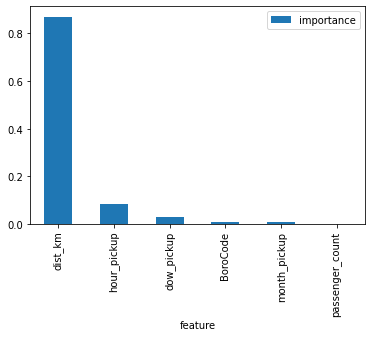

In [ ]:
importances = pd.DataFrame({'feature':train_X.columns,'importance':np.round(random_forest_grid.best_estimator_.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()

# Pt.1 Train vanilla neural network

In [17]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(256, kernel_initializer='normal',input_dim = ds_train.shape[1]-1, activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer='adam', metrics=keras.losses.MeanSquaredLogarithmicError())
NN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               1792      
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 dense_17 (Dense)            (None, 256)               65792     
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 199,425
Trainable params: 199,425
Non-trainable params: 0
_________________________________________________________________


In [15]:
#set checkpoints
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_mean_squared_logarithmic_error', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [16]:
history = NN_model.fit(x_values, y_values, epochs=200, batch_size=1024, validation_split = 0.25, callbacks=[callbacks_list])


Epoch 1/200
1061/1062 [============================>.] - ETA: 0s - loss: 0.5570 - mean_squared_logarithmic_error: 0.5570
Epoch 1: val_mean_squared_logarithmic_error improved from inf to 0.23773, saving model to Weights-001--0.23765.hdf5
1062/1062 [==============================] - 9s 5ms/step - loss: 0.5567 - mean_squared_logarithmic_error: 0.5566 - val_loss: 0.2376 - val_mean_squared_logarithmic_error: 0.2377
Epoch 2/200
1061/1062 [============================>.] - ETA: 0s - loss: 0.1815 - mean_squared_logarithmic_error: 0.1815
Epoch 2: val_mean_squared_logarithmic_error improved from 0.23773 to 0.22784, saving model to Weights-002--0.22775.hdf5
1062/1062 [==============================] - 5s 5ms/step - loss: 0.1815 - mean_squared_logarithmic_error: 0.1815 - val_loss: 0.2278 - val_mean_squared_logarithmic_error: 0.2278
Epoch 3/200
1061/1062 [============================>.] - ETA: 0s - loss: 0.1771 - mean_squared_logarithmic_error: 0.1771
Epoch 3: val_mean_squared_logarithmic_error imp

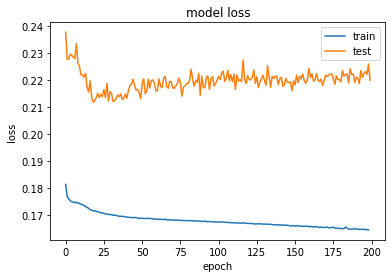

In [19]:
#plot the viz of train and val error
plt.plot(history.history['mean_squared_logarithmic_error'][1:])
plt.plot(history.history['val_mean_squared_logarithmic_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Pt.2 Perform one hot encoding

### One hot encoding categorical features

In [47]:
#one hot encoding variable "BoroCode"
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('int64')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
ds_train_OHE = ds_train.copy()
ds_train_OHE = oneHotEncode(ds_train_OHE, ["hour_pickup"])
ds_train_OHE = oneHotEncode(ds_train_OHE, ["dow_pickup"])
ds_train_OHE = oneHotEncode(ds_train_OHE, ["BoroCode"])
ds_train_OHE = oneHotEncode(ds_train_OHE, ["month_pickup"])

In [48]:
#predict variable split
y_values = ds_train_OHE["trip_duration"]
x_values = ds_train_OHE.drop(["trip_duration"],axis=1)

In [22]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(256, kernel_initializer='normal',input_dim = ds_train_OHE.shape[1]-1, activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer='adam', metrics=keras.losses.MeanSquaredLogarithmicError())
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               11520     
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 209,153
Trainable params: 209,153
Non-trainable params: 0
_________________________________________________________________


In [23]:
#set checkpoints
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_mean_squared_logarithmic_error', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [24]:
history = NN_model.fit(x_values, y_values, epochs=200, batch_size=1024, validation_split = 0.25, callbacks=[callbacks_list])

Epoch 1/200
1057/1062 [============================>.] - ETA: 0s - loss: 0.6715 - mean_squared_logarithmic_error: 0.6715
Epoch 1: val_mean_squared_logarithmic_error improved from inf to 0.18531, saving model to Weights-001--0.18526.hdf5
1062/1062 [==============================] - 7s 6ms/step - loss: 0.6693 - mean_squared_logarithmic_error: 0.6692 - val_loss: 0.1853 - val_mean_squared_logarithmic_error: 0.1853
Epoch 2/200
1057/1062 [============================>.] - ETA: 0s - loss: 0.1750 - mean_squared_logarithmic_error: 0.1750
Epoch 2: val_mean_squared_logarithmic_error improved from 0.18531 to 0.18137, saving model to Weights-002--0.18131.hdf5
1062/1062 [==============================] - 7s 7ms/step - loss: 0.1749 - mean_squared_logarithmic_error: 0.1749 - val_loss: 0.1813 - val_mean_squared_logarithmic_error: 0.1814
Epoch 3/200
1051/1062 [============================>.] - ETA: 0s - loss: 0.1729 - mean_squared_logarithmic_error: 0.1729
Epoch 3: val_mean_squared_logarithmic_error imp

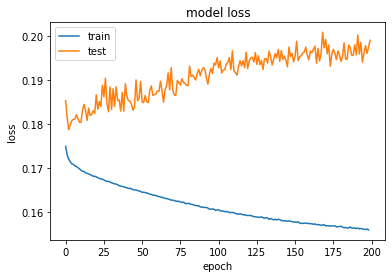

In [25]:
#plot the viz of train and val error
plt.plot(history.history['mean_squared_logarithmic_error'][1:])
plt.plot(history.history['val_mean_squared_logarithmic_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Pt.3 Fix circular values and one hot encoding

### Circular predictors for hours, month and day_of_week variables

In [49]:
#one hot encoding variable BoroCode
ds_train = oneHotEncode(ds_train, ["BoroCode"])

In [50]:
#hours
ds_train['sin_hour_pickup'] = np.sin(np.pi*ds_train.hour_pickup/24)
ds_train['cos__hour_pickup'] = np.cos(np.pi*ds_train.hour_pickup/24)
ds_train.drop('hour_pickup', axis=1, inplace=True)

In [51]:
#month
ds_train['sin_month_pickup'] = np.sin(np.pi*ds_train.month_pickup/12)
ds_train['cos__month_pickup'] = np.cos(np.pi*ds_train.month_pickup/12)
ds_train.drop('month_pickup', axis=1, inplace=True)

In [52]:
#day of the week
ds_train['sin_dow_pickup'] = np.sin(np.pi*ds_train.dow_pickup/7)
ds_train['cos__dow_pickup'] = np.cos(np.pi*ds_train.dow_pickup/7)
ds_train.drop('dow_pickup', axis=1, inplace=True)

In [53]:
#predict variable split
y_values = ds_train["trip_duration"]
x_values = ds_train.drop(["trip_duration"],axis=1)

In [54]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(256, kernel_initializer='normal',input_dim = ds_train.shape[1]-1, activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer='adam', metrics=keras.losses.MeanSquaredLogarithmicError())
NN_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 256)               3584      
                                                                 
 dense_26 (Dense)            (None, 256)               65792     
                                                                 
 dense_27 (Dense)            (None, 256)               65792     
                                                                 
 dense_28 (Dense)            (None, 256)               65792     
                                                                 
 dense_29 (Dense)            (None, 1)                 257       
                                                                 
Total params: 201,217
Trainable params: 201,217
Non-trainable params: 0
_________________________________________________________________


In [55]:
#set checkpoints
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_mean_squared_logarithmic_error', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [56]:
history = NN_model.fit(x_values, y_values, epochs=200, batch_size=1024, validation_split = 0.25, callbacks=[callbacks_list])

Epoch 1/200
1062/1062 [==============================] - ETA: 0s - loss: 0.7124 - mean_squared_logarithmic_error: 0.7123
Epoch 1: val_mean_squared_logarithmic_error improved from inf to 0.19811, saving model to Weights-001--0.19806.hdf5
1062/1062 [==============================] - 30s 28ms/step - loss: 0.7124 - mean_squared_logarithmic_error: 0.7123 - val_loss: 0.1981 - val_mean_squared_logarithmic_error: 0.1981
Epoch 2/200
1061/1062 [============================>.] - ETA: 0s - loss: 0.1815 - mean_squared_logarithmic_error: 0.1815
Epoch 2: val_mean_squared_logarithmic_error improved from 0.19811 to 0.19435, saving model to Weights-002--0.19427.hdf5
1062/1062 [==============================] - 30s 28ms/step - loss: 0.1815 - mean_squared_logarithmic_error: 0.1815 - val_loss: 0.1943 - val_mean_squared_logarithmic_error: 0.1943
Epoch 3/200
1061/1062 [============================>.] - ETA: 0s - loss: 0.1772 - mean_squared_logarithmic_error: 0.1772
Epoch 3: val_mean_squared_logarithmic_error

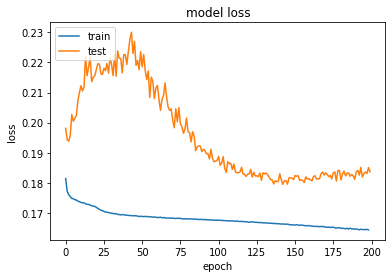

In [57]:
#plot the viz of train and val error
plt.plot(history.history['mean_squared_logarithmic_error'][1:])
plt.plot(history.history['val_mean_squared_logarithmic_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Pt.4 Fix overfitting (L2, dropout and early stopping)

Comparing results from pt2 and pt3 comes out that using OHE in all categorical values gives better results. So from now on I'll stick with that

In [37]:
#predict variable split
y_values = ds_train_OHE["trip_duration"]
x_values = ds_train_OHE.drop(["trip_duration"],axis=1)

Add L2 regularization and dropout

In [42]:
#L2 factor
factor=0.0001
#Dropout rate
rate=0.3

NN_model = Sequential()
# The Input Layer :
NN_model.add(Dense(256, kernel_initializer='normal',input_dim = ds_train_OHE.shape[1]-1, kernel_regularizer=l2(factor), activation='relu'))--

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal', kernel_regularizer=l2(factor), activation='relu'))
NN_model.add(Dropout(rate))
NN_model.add(Dense(256, kernel_initializer='normal', kernel_regularizer=l2(factor), activation='relu'))
NN_model.add(Dropout(rate))
NN_model.add(Dense(256, kernel_initializer='normal', kernel_regularizer=l2(factor), activation='relu'))
NN_model.add(Dropout(rate))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer='adam', metrics=keras.losses.MeanSquaredLogarithmicError())
NN_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               11520     
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)              

In [43]:
#set up early stopping and checkpoints
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_mean_squared_logarithmic_error', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

Add early stop

In [44]:
#fit model
history = NN_model.fit(x_values, y_values, epochs=200, batch_size=1024, validation_split = 0.25, callbacks=[callbacks_list, es])

Epoch 1/200
1061/1062 [============================>.] - ETA: 0s - loss: 0.6810 - mean_squared_logarithmic_error: 0.6341
Epoch 1: val_mean_squared_logarithmic_error improved from inf to 0.19428, saving model to Weights-001--0.23298.hdf5
1062/1062 [==============================] - 6s 5ms/step - loss: 0.6807 - mean_squared_logarithmic_error: 0.6336 - val_loss: 0.2330 - val_mean_squared_logarithmic_error: 0.1943
Epoch 2/200
1061/1062 [============================>.] - ETA: 0s - loss: 0.2212 - mean_squared_logarithmic_error: 0.1878
Epoch 2: val_mean_squared_logarithmic_error improved from 0.19428 to 0.18753, saving model to Weights-002--0.21620.hdf5
1062/1062 [==============================] - 5s 5ms/step - loss: 0.2212 - mean_squared_logarithmic_error: 0.1878 - val_loss: 0.2162 - val_mean_squared_logarithmic_error: 0.1875
Epoch 3/200
1054/1062 [============================>.] - ETA: 0s - loss: 0.2092 - mean_squared_logarithmic_error: 0.1841
Epoch 3: val_mean_squared_logarithmic_error imp

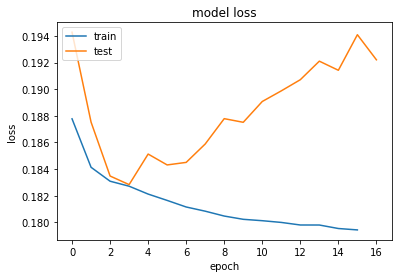

In [45]:
#plot the viz of train and val error
plt.plot(history.history['mean_squared_logarithmic_error'][1:])
plt.plot(history.history['val_mean_squared_logarithmic_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model explanation with LIME

In [46]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_values),
    feature_names=x_values.columns,
    mode='regression')

In [47]:
idx = random.randint(1, len(x_values))
explanation = explainer.explain_instance(x_values.iloc[idx], NN_model.predict, num_features=len(x_values.columns))
explanation

In [48]:
explanation.show_in_notebook()

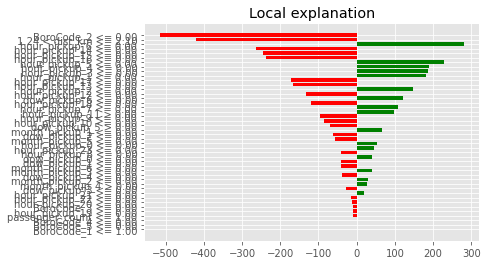

In [49]:
with plt.style.context("ggplot"):
    explanation.as_pyplot_figure()

In [50]:
print("Explanation Local Prediction  : ", explanation.local_pred)
print("Explanation Global Prediction : ", explanation.predicted_value)

Explanation Local Prediction  :  [557.19032088]
Explanation Global Prediction :  488.71732


# Save best model with pickle

In [51]:
import pickle
pickle.dump(NN_model, open("/NN_model.model", 'wb'))

INFO:tensorflow:Assets written to: ram://b5932898-99ae-4013-a8b9-0ca36a462abc/assets


# Test predict

In [52]:
from math import radians, cos, sin, asin, sqrt

In [54]:
#Dataset load
ds_test = pd.read_csv("/test.zip" , compression="zip")

In [55]:
ds_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


## Preformatting test dataset

In [56]:
#to_datetime columns
ds_test['pickup_datetime'] = pd.to_datetime(ds_test.pickup_datetime)
ds_train.loc[:, 'pickup_date'] = ds_test['pickup_datetime'].dt.date
#add columns to split datetimes
ds_test['month_pickup'] = [date.month for date in ds_test.pickup_datetime]
ds_test['day_pickup'] = [date.day for date in ds_test.pickup_datetime]
ds_test['dow_pickup'] = [date.dayofweek for date in ds_test.pickup_datetime]
ds_test['hour_pickup'] = [date.hour for date in ds_test.pickup_datetime]

In [57]:
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

#Add/update a column to the data frame with the distances (in metres)
ds_test['dist_km'] = ds_test.apply(lambda x : haversine(x['pickup_longitude'], x['pickup_latitude'], x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

In [59]:
!pip uninstall rtree
!apt install libspatialindex-dev
!pip install rtree
!pip install pandas fiona shapely pyproj
!pip install geopandas
import rtree
import geopandas as gpd
import fiona
from shapely.geometry import Point, Polygon
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(ds_test['pickup_longitude'], ds_test['pickup_latitude'])]
geo_df = gpd.GeoDataFrame(ds_test, crs = crs, geometry = geometry)
ny_bb = gpd.read_file(gpd.datasets.get_path('nybb'))
ny_bb.to_crs(epsg=4326, inplace=True)
join = gpd.sjoin(geo_df, ny_bb, how="left")
ds_test = join.copy()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (823 kB/s)
Selecting previously unselected package libspatialindex

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  from ipykernel import kernelapp as app


In [60]:
ds_test["BoroCode"].fillna(1.0, inplace = True)
ds_test = ds_test.astype({"BoroCode": int})
ds_test = oneHotEncode(ds_test, ["hour_pickup"])
ds_test = oneHotEncode(ds_test, ["dow_pickup"])
ds_test = oneHotEncode(ds_test, ["BoroCode"])
ds_test = oneHotEncode(ds_test, ["month_pickup"])

In [61]:
ds_test.drop(["vendor_id", "pickup_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "store_and_fwd_flag",
              "day_pickup", "geometry", "index_right", "BoroName", "Shape_Leng", "Shape_Area", ],inplace=True, axis=1)

## Predict

In [62]:
ds_test["trip_duration"] = NN_model.predict(ds_test.drop(["id"], axis=1))

In [63]:
ds_test.columns

Index(['id', 'passenger_count', 'dist_km', 'hour_pickup_0', 'hour_pickup_1',
       'hour_pickup_2', 'hour_pickup_3', 'hour_pickup_4', 'hour_pickup_5',
       'hour_pickup_6', 'hour_pickup_7', 'hour_pickup_8', 'hour_pickup_9',
       'hour_pickup_10', 'hour_pickup_11', 'hour_pickup_12', 'hour_pickup_13',
       'hour_pickup_14', 'hour_pickup_15', 'hour_pickup_16', 'hour_pickup_17',
       'hour_pickup_18', 'hour_pickup_19', 'hour_pickup_20', 'hour_pickup_21',
       'hour_pickup_22', 'hour_pickup_23', 'dow_pickup_0', 'dow_pickup_1',
       'dow_pickup_2', 'dow_pickup_3', 'dow_pickup_4', 'dow_pickup_5',
       'dow_pickup_6', 'BoroCode_1', 'BoroCode_2', 'BoroCode_3', 'BoroCode_4',
       'BoroCode_5', 'month_pickup_1', 'month_pickup_2', 'month_pickup_3',
       'month_pickup_4', 'month_pickup_5', 'month_pickup_6', 'trip_duration'],
      dtype='object')

In [64]:
pred = ds_test.drop(['passenger_count', 'dist_km', 'hour_pickup_0', 'hour_pickup_1',
       'hour_pickup_2', 'hour_pickup_3', 'hour_pickup_4', 'hour_pickup_5',
       'hour_pickup_6', 'hour_pickup_7', 'hour_pickup_8', 'hour_pickup_9',
       'hour_pickup_10', 'hour_pickup_11', 'hour_pickup_12', 'hour_pickup_13',
       'hour_pickup_14', 'hour_pickup_15', 'hour_pickup_16', 'hour_pickup_17',
       'hour_pickup_18', 'hour_pickup_19', 'hour_pickup_20', 'hour_pickup_21',
       'hour_pickup_22', 'hour_pickup_23', 'dow_pickup_0', 'dow_pickup_1',
       'dow_pickup_2', 'dow_pickup_3', 'dow_pickup_4', 'dow_pickup_5',
       'dow_pickup_6', 'BoroCode_1', 'BoroCode_2', 'BoroCode_3', 'BoroCode_4',
       'BoroCode_5', 'month_pickup_1', 'month_pickup_2', 'month_pickup_3',
       'month_pickup_4', 'month_pickup_5', 'month_pickup_6'], axis=1)

In [65]:
pred.to_csv("../pred.csv", index=False)